In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import json
import torch
import torchaudio
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import Audio
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2ForSequenceClassification
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

import umap.umap_ as umap
import matplotlib.pyplot as plt

from functions import AudioMNISTDataset, create_dataloaders, collate_fn

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def plot_umap(features, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42):
    # Ensure 'features' is a numpy array
    assert isinstance(features, np.ndarray), "Features must be a numpy array"
    assert isinstance(labels, np.ndarray), "Labels must be a numpy array"

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='tab10', s=5)
    plt.colorbar(scatter)
    plt.title("UMAP Projection of Features")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [3]:
# Reload the processor (optional but useful if needed for inference)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

dataloaders = create_dataloaders("AudioMNIST/data/", processor, batch_size=16)

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

In [4]:
# Load saved model
model1 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model1.load_state_dict(torch.load("seq-class-head.pth", weights_only=True))
model1.to(device)
model1.eval()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [5]:
# Load saved model
model2 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model2.load_state_dict(torch.load("seq-class-fine.pth", weights_only=True))
model2.to(device)
model2.eval()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


### UMAP of model1 (only class head)

In [6]:
def hook(module, input, output):
    # Apply mean pooling over the sequence length dimension (dim=1)
    pooled_output = output[1].mean(dim=1)  # Shape: [batch_size, 768]
    projector_features.append(pooled_output.detach())

In [7]:
def register_hook(layer):
    """
    Registers a forward hook to store features in the dynamically provided storage.

    Args:
        layer (nn.Module): The layer to which the hook should be attached.
        feature_storage (list): A mutable list to store the features extracted by the hook.
    
    Returns:
        hook_handle (torch.utils.hooks.RemovableHandle): Handle to manage the hook lifecycle.
    """
    feature_storage = []
    def hook(module, input, output):
        
        if isinstance(output, tuple):
            output = output[1] # POSSIBLE PROBLEM IF WE NEED output[0]. IN THIS CASE THE OUTPUT TENSOR IS IN SECOND ELEMENT OF TUPLE
        
        #elif isinstance(output, torch.Tensor):
            # do nothing - output is correct

        # Apply mean pooling over the sequence length dimension (dim=1)
        pooled_output = output.mean(dim=1)  # Shape: [batch_size, 768]
        feature_storage.append(pooled_output.detach())  # Append the pooled output to the passed storage

    # Register the hook
    hook_handle = layer.register_forward_hook(hook)
    return hook_handle, feature_storage

In [9]:
def forward_pass(model, dataloader):
    with torch.no_grad():
        all_labels = []
        for batch in dataloader:
            input_values, labels = batch
            input_values = input_values.to(device)
            labels = labels.to(device)
    
            # Forward pass
            outputs = model(input_values)
            all_labels.append(labels.cpu())
    return all_labels

In [11]:
projector_hook, projector_features = register_hook(model1.projector)
feat_hook, feature_projection_features = register_hook(model1.wav2vec2.feature_projection)

all_labels = forward_pass(model1, test_loader)

# Remove the hook after extraction
projector_hook.remove()
feat_hook.remove()

# Stack the collected features and labels
projector_features = torch.cat(projector_features, dim=0)
feat_hook_features = torch.cat(feature_projection_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to NumPy for UMAP
projector_features_np = projector_features.cpu().numpy()
feat_hook_features_np = feat_hook_features.cpu().numpy()
labels_np = all_labels.cpu().numpy()

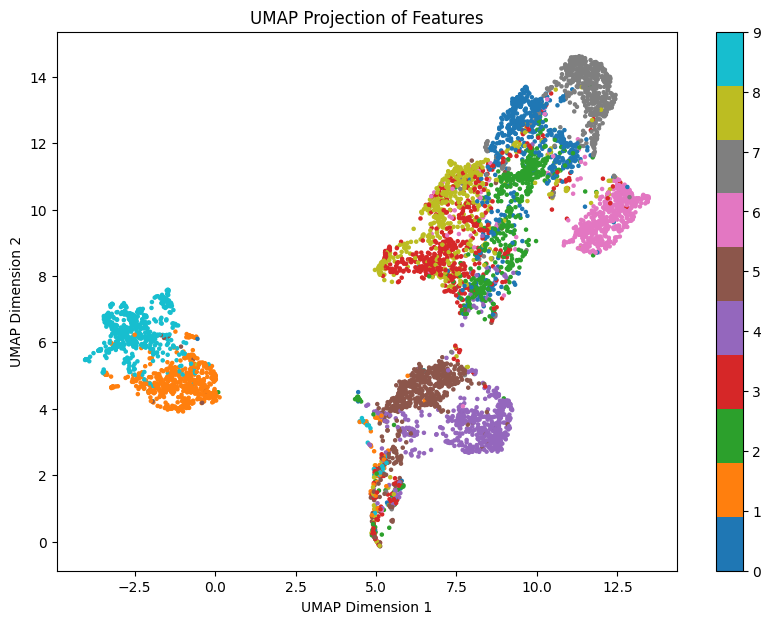

In [12]:
plot_umap(projector_features_np, labels_np)
#plot_umap(feat_hook_features_np, labels_np)

### UMAP of model2 (fine-tuned)

In [13]:
ph2, pf2 = register_hook(model2.projector)
fh2, fpf2 = register_hook(model2.wav2vec2.feature_projection)

all_labels = forward_pass(model2, test_loader)

# Remove the hook after extraction
ph2.remove()
fh2.remove()

# Stack the collected features and labels
pf2 = torch.cat(pf2, dim=0)
fpf2 = torch.cat(fpf2, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to NumPy for UMAP
pf2_np = pf2.cpu().numpy()
fpf2_np = fpf2.cpu().numpy()
labels_np = all_labels.cpu().numpy()

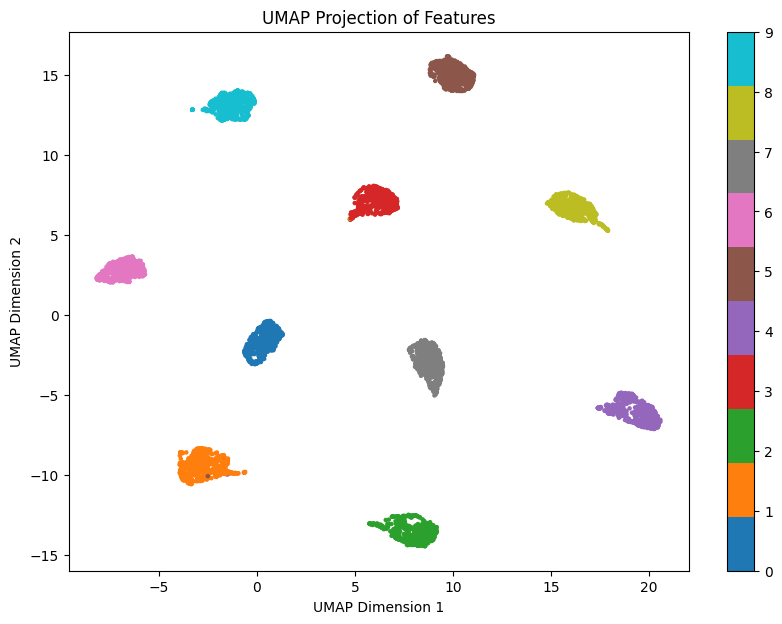

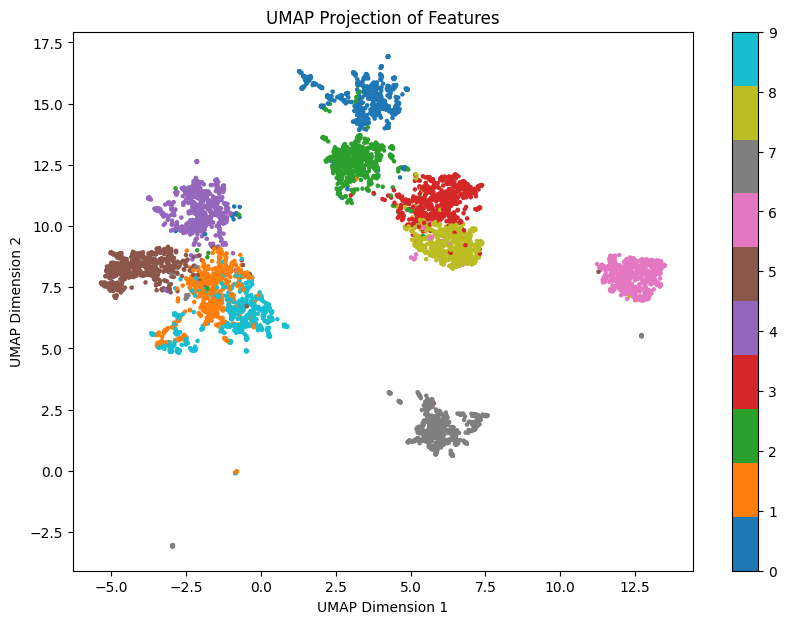

In [14]:
plot_umap(pf2_np, labels_np)
plot_umap(fpf2_np, labels_np)